In [1]:
# parameters
start_year = 2009
start_month = 1
start_day = 1

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from tqdm import tqdm

In [4]:
INALT_mask=xr.open_dataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc')
particle_ds = xr.open_dataset(f'/gxfs_work/geomar/smomw523/master-thesis/output_data/INALT20.L46-KFS119/Track-Column_test_1500_{start_year:04d}{start_month:02d}{start_day:02d}_RT-42_N-100000_seed-12345.nc')
SIGMA=xr.open_dataset('/gxfs_work/geomar/smomw523/master-thesis/data/config/ROMS/sigma2depth_parent.nc')
ROMS_ds = xr.open_dataset(f'/gxfs_work/geomar/smomw523/master-thesis/output_data/ROMS/Track-Column_test_1500_{start_year:04d}{start_month:02d}{start_day:02d}_RT-42_N-100000_seed-12345.nc')
SIGMA_child=xr.open_dataset('/gxfs_work/geomar/smomw523/master-thesis/data/config/ROMS/sigma2depth_child.nc')
ROMSchild_ds = xr.open_dataset(f'/gxfs_work/geomar/smomw523/master-thesis/output_data/ROMS_child/Track-Column_test_1500_{start_year:04d}{start_month:02d}{start_day:02d}_RT-42_N-100000_seed-12345.nc')
ROMS_ds

<xarray.Dataset>
Dimensions:     (traj: 100000, obs: 44)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 ...
    lat         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
    topography  (traj, obs) float32 ...
    distance    (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

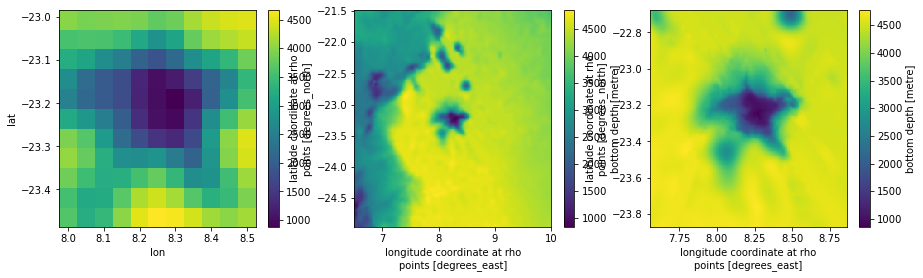

In [4]:
topo_INALT = np.sum((INALT_mask.tmask*INALT_mask.e3t_0).isel(t=0),axis=0)
topo_INALT = topo_INALT.assign_coords({"lon": INALT_mask.glamt.isel(t=0,y=0),
                                       "lat": INALT_mask.gphit.isel(t=0,x=0),
                                      })
topo_INALT = topo_INALT.swap_dims({'x': 'lon', 'y': 'lat'})

plt.figure(figsize=(15,4))
plt.subplot(1, 3,1)
topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)).plot()
plt.subplot(1, 3,2)
SIGMA.h.plot()
plt.subplot(1, 3,3)
SIGMA_child.h.plot();

In [5]:
releasepoints_INALT = pd.read_csv('/gxfs_work1/geomar/smomw523/master-thesis/data/config/releasepoints_INALT.csv',usecols=[2,1]).reindex(columns=['lon','lat'])
releasepoints_ROMS = pd.read_csv('/gxfs_work1/geomar/smomw523/master-thesis/data/config/releasepoints_ROMS.csv',usecols=[2,1]).reindex(columns=['lon','lat'])
releasepoints_ROMSchild = pd.read_csv('/gxfs_work1/geomar/smomw523/master-thesis/data/config/releasepoints_ROMSchild.csv',usecols=[2,1]).reindex(columns=['lon','lat'])

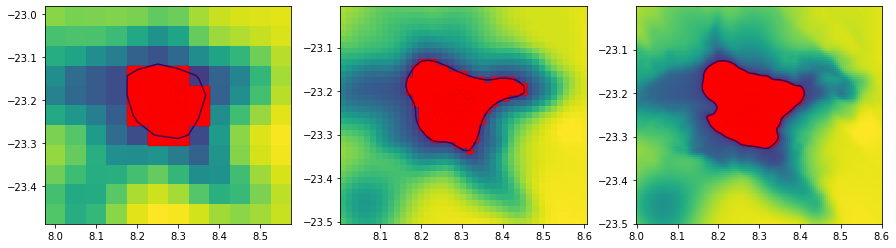

In [6]:
plt.figure(figsize=(15,4))
plt.subplot(1, 3,1)
plt.pcolormesh(topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)))#,levels=20)
cl_INALT=plt.contour(topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)),levels=[1500])
plt.scatter(releasepoints_INALT['lon'],releasepoints_INALT['lat'],s=0.01,color='red')

plt.subplot(1, 3,2)
plt.pcolormesh(SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)))#,levels=20)
cl_ROMS=plt.contour(SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)),levels=[1500])
plt.scatter(releasepoints_ROMS['lon'],releasepoints_ROMS['lat'],s=0.01,color='red')
#ROMS_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.01,color='red')

plt.subplot(1, 3,3)
plt.pcolormesh(SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)))#,levels=20)
cl_ROMSchild=plt.contour(SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)),levels=[1500])
plt.scatter(releasepoints_ROMSchild['lon'],releasepoints_ROMSchild['lat'],s=0.01,color='red')
#ROMSchild_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.01,color='red');

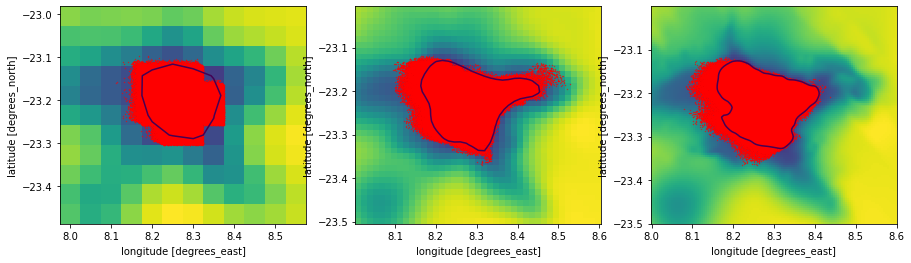

In [7]:
plt.figure(figsize=(15,4))
plt.subplot(1, 3,1)
plt.pcolormesh(topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)))#,levels=20)
cl_INALT=plt.contour(topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)),levels=[1500])
particle_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.1,color='red')

plt.subplot(1, 3,2)
plt.pcolormesh(SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)))#,levels=20)
cl_ROMS=plt.contour(SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)),levels=[1500])
ROMS_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.1,color='red')

plt.subplot(1, 3,3)
plt.pcolormesh(SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)))#,levels=20)
cl_ROMSchild=plt.contour(SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)),levels=[1500])
ROMSchild_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.1,color='red');

In [8]:
hull_INALT=ConvexHull(releasepoints_INALT.to_numpy())
hull_ROMS=ConvexHull(releasepoints_ROMS.to_numpy())
hull_ROMSchild=ConvexHull(releasepoints_ROMSchild.to_numpy())

#INALT
x = np.array([8.175, 8.325, 8.325, 8.375, 8.375,
              8.325, 8.325, 8.225, 8.225, 8.175])
y = np.array([-23.12069, -23.12069, -23.1666665, -23.1666665, -23.2585715,
              -23.2585715, -23.3045005, -23.3045005, -23.2585715, -23.2585715])
#x = releasepoints_INALT.to_numpy()[hull_INALT.vertices, 0]
#y = releasepoints_INALT.to_numpy()[hull_INALT.vertices, 1]
#z = releasepoints_INALT.to_numpy()[hull_INALT.vertices, 2]
poly_INALT = Polygon([(i[0], i[1]) for i in zip(x,y)])
    
#ROMS
x  =np.array([8.1644115,8.1791175,8.1791175,8.193824,8.193824,
          8.2379415,8.2379415,8.267353,8.267353,8.3114705,8.3114705,
          8.355588,8.355588,8.370294,8.370294,8.4291175,8.4291175,
          8.4585295,8.4585295,8.4144115,8.4144115,8.385,8.385,8.370294,
          8.370294,8.355588,8.355588,8.340882,8.340882,8.3261765,8.3261765,
          8.3114705,8.3114705,8.282059,8.282059,8.223235,8.223235,8.2085295,
          8.2085295,8.193824,8.193824,8.1791175,8.1791175,8.1644115])
y = np.array([-23.1675815,-23.1675815,-23.14054,-23.14054,-23.127018,-23.127018,
          -23.14054,-23.14054,-23.154061,-23.154061,-23.1675815,-23.1675815,
          -23.1811,-23.1811,-23.1675815,-23.1675815,-23.1811,-23.1811,-23.2081335,
          -23.2081335,-23.221648,-23.221648,-23.235161,-23.235161,-23.2486725,-23.2486725,
          -23.275692,-23.275692,-23.316211,-23.316211,-23.343217,-23.343217,-23.329715,
          -23.329715,-23.316211,-23.316211,-23.302706,-23.302706,-23.2892,-23.2892,
          -23.235161,-23.235161,-23.2081335,-23.2081335])
#x = cl_ROMS.collections[0].get_paths()[0].vertices[:, 0] #releasepoints_ROMS.to_numpy()[hull_ROMS.vertices, 0]
#y = cl_ROMS.collections[0].get_paths()[0].vertices[:, 1] #releasepoints_ROMS.to_numpy()[hull_ROMS.vertices, 1]
#z = releasepoints_ROMS.to_numpy()[hull_ROMS.vertices, 2]
poly_ROMS = Polygon([(i[0], i[1]) for i in zip(x,y)])
    
#ROMSchild
x = cl_ROMSchild.collections[0].get_paths()[0].vertices[:, 0] #releasepoints_ROMSchild.to_numpy()[hull_ROMSchild.vertices, 0]
y = cl_ROMSchild.collections[0].get_paths()[0].vertices[:, 1] #releasepoints_ROMSchild.to_numpy()[hull_ROMSchild.vertices, 1]
#z = releasepoints_ROMSchild.to_numpy()[hull_ROMSchild.vertices, 2]
poly_ROMSchild = Polygon([(i[0], i[1]) for i in zip(x,y)])

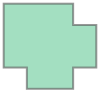

In [9]:
poly_INALT

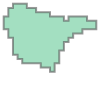

In [10]:
poly_ROMS

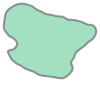

In [11]:
poly_ROMSchild

In [12]:
#particle_ds['depthdiff'] = particle_ds.topography-particle_ds.z
ROMS_ds['depthdiff'] = ROMS_ds.topography-ROMS_ds.z
ROMSchild_ds['depthdiff'] = ROMSchild_ds.topography-ROMSchild_ds.z

In [13]:
df_INALT1 = particle_ds.to_dataframe()
df_ROMS1 = ROMS_ds.to_dataframe()
df_ROMSchild1 = ROMSchild_ds.to_dataframe()

CPU times: user 785 ms, sys: 1.9 s, total: 2.68 s
Wall time: 2.7 s


In [14]:
%%time

df_INALT1["is_in_column"] = df_INALT1.apply(lambda row: poly_INALT.contains(
    Point(row.loc["lon"], row.loc["lat"])), axis=1)

df_ROMS1["is_in_column"] = df_ROMS1.apply(lambda row: poly_ROMS.contains(
     Point(row.loc["lon"], row.loc["lat"])), axis=1)

df_ROMSchild1["is_in_column"] = df_ROMSchild1.apply(lambda row: poly_ROMSchild.contains(
     Point(row.loc["lon"], row.loc["lat"])), axis=1)

CPU times: user 8min 6s, sys: 5.37 s, total: 8min 11s
Wall time: 8min 13s


In [15]:
INALT_1bool_xr, ROMS_1bool_xr, ROMSchild_1bool_xr = df_INALT1.to_xarray(), df_ROMS1.to_xarray(), df_ROMSchild1.to_xarray()

In [60]:
%%time

exit_obs_index_INALT, exit_obs_index_ROMS, exit_obs_index_ROMSchild = [], [], []
exit_z_INALT, exit_z_ROMS, exit_z_ROMSchild = [], [], []
exitdepthdiff_INALT, exitdepthdiff_ROMS, exitdepthdiff_ROMSchild = [], [], []
exitdistance_INALT, exitdistance_ROMS, exitdistance_ROMSchild = [], [], []

for i in tqdm(range(len(INALT_1bool_xr.traj)),desc="traj_INALT"):
    obs_index_INALT = INALT_1bool_xr.isel(traj=i).is_in_column.idxmin(dim='obs').values.min()-1
    exit_obs_index_INALT.append(obs_index_INALT)
    z_INALT = INALT_1bool_xr.isel(traj=i, obs=obs_index_INALT).z.values.min()
    exit_z_INALT.append(z_INALT)
    exit_INALT = INALT_1bool_xr.isel(traj=i, obs=obs_index_INALT).depthdiff.values.min()
    exitdepthdiff_INALT.append(exit_INALT)
    distance_INALT = INALT_1bool_xr.isel(traj=i, obs=obs_index_INALT).distance.values.min()
    exitdistance_INALT.append(distance_INALT)
    
for i in tqdm(range(len(ROMS_1bool_xr.traj)),desc="traj_ROMS"):
    obs_index_ROMS = ROMS_1bool_xr.isel(traj=i).is_in_column.idxmin(dim='obs').values.min()-1
    exit_obs_index_ROMS.append(obs_index_ROMS)
    z_ROMS = ROMS_1bool_xr.isel(traj=i, obs=obs_index_ROMS).z.values.min()
    exit_z_ROMS.append(z_ROMS)
    exit_ROMS = ROMS_1bool_xr.isel(traj=i, obs=obs_index_ROMS).depthdiff.values.min()
    exitdepthdiff_ROMS.append(exit_ROMS)
    distance_ROMS = ROMS_1bool_xr.isel(traj=i, obs=obs_index_ROMS).distance.values.min()
    exitdistance_ROMS.append(distance_ROMS)
    
for i in tqdm(range(len(ROMSchild_1bool_xr.traj)),desc="traj_ROMSchild"):
    obs_index_ROMSchild = ROMSchild_1bool_xr.isel(traj=i).is_in_column.idxmin(dim='obs').values.min()-1
    exit_obs_index_ROMSchild.append(obs_index_ROMSchild)
    z_ROMSchild = ROMSchild_1bool_xr.isel(traj=i, obs=obs_index_ROMSchild).z.values.min()
    exit_z_ROMSchild.append(z_ROMSchild)
    exit_ROMSchild = ROMSchild_1bool_xr.isel(traj=i, obs=obs_index_ROMSchild).depthdiff.values.min()
    exitdepthdiff_ROMSchild.append(exit_ROMSchild)
    distance_ROMSchild = ROMSchild_1bool_xr.isel(traj=i, obs=obs_index_ROMSchild).distance.values.min()
    exitdistance_ROMSchild.append(distance_ROMSchild)

traj_ROMSchild: 100%|██████████████████| 100000/100000 [02:39<00:00, 627.26it/s]

CPU times: user 7min 58s, sys: 3.3 s, total: 8min 1s
Wall time: 7min 54s


In [63]:
dict = {'INALT-obs': exit_obs_index_INALT,'INALT-z': exit_z_INALT,'INALT-diff': exitdepthdiff_INALT,'INALT-distance': exitdistance_INALT,
        'ROMS-obs': exit_obs_index_ROMS,'ROMS-z': exit_z_ROMS,'INALT-z': exit_z_INALT,'ROMS-diff': exitdepthdiff_ROMS,'ROMS-distance': exitdistance_ROMS,
        'ROMSchild-obs': exit_obs_index_ROMSchild,'ROMSchild-z': exit_z_ROMSchild,'ROMSchild-diff': exitdepthdiff_ROMSchild,'ROMSchild-distance': exitdistance_ROMSchild,
       }

In [64]:
pd.DataFrame(dict).to_csv(f'/gxfs_work1/geomar/smomw523/master-thesis/output_data/retention/tiefenunabhängig/{start_year:04d}{start_month:02d}{start_day:02d}.csv')